## Setup

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import statsmodels.tsa as tsa
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, LogisticRegression, LinearRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, f1_score, make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier, DummyRegressor

from eptest_main import read_ep_data, get_ct_dfs, adjust_ct_dfs, get_rolling_cts, get_interp_swaps
from eptest_main import test_adfuller, RegressionMain, get_norm_cts, get_norm_curve_diffs
from eptest_main import CT_SWAP_MAP, CT_SIZES, COT_COLS, PRICE_DUR_COLS
from Modelling.classification import *

legacy, tff, futures, swaps_raw = read_ep_data()
swaps = get_interp_swaps(swaps_raw)

# Preprocessing + PCA

In [2]:
swaps.head()

,2y,5y,7y,10y,15y,20y,30y,swap_US,25y
2010-01-01,1.4117,2.9684,3.5285,3.9500,4.3458,4.4542,4.5175,4.3458,4.48585
2010-01-04,1.3450,2.9231,3.4801,3.9340,4.3372,4.4431,4.5100,4.3372,4.47655
2010-01-05,1.2968,2.8480,3.3975,3.8550,4.2645,4.3876,4.4590,4.2645,4.42330
2010-01-06,1.2740,2.8858,3.4545,3.9255,4.3355,4.4631,4.5350,4.3355,4.49905
2010-01-07,1.3020,2.9148,3.4765,3.9435,4.3520,4.4770,4.5585,4.3520,4.51775


In [3]:
idx = pd.IndexSlice
futures.loc[:, idx[:, 'PX_LAST']].tail()

ct,TU,FV,TY,US,WN
field,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST
2020-10-14,110.437500,125.890625,139.218750,175.37500,220.15625
2020-10-15,110.437500,125.843750,139.125000,175.25000,219.84375
2020-10-16,110.429688,125.820312,139.062500,174.90625,218.93750
2020-10-19,110.425781,125.757812,138.921875,174.50000,218.25000
2020-10-20,110.425781,125.718750,138.703125,173.50000,215.81250


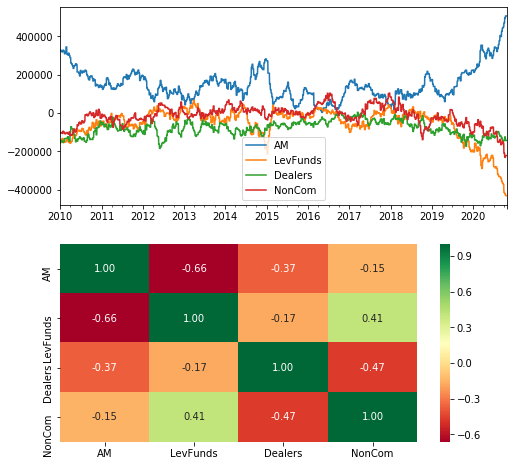

In [4]:

# look at historical CTD mty?
# wish i could get invoice spreads data more easily

# break the data as of measurement for initial modeling purposes
ct_dfs = get_ct_dfs(legacy, tff, futures, swaps)

ct_dfs['US'].head()
fig, ax = plt.subplots(figsize=(8,8), nrows=2)
ct_dfs['US'].loc[:, ['AM', 'LevFunds', 'Dealers', 'NonCom']].plot(ax=ax[0])
sns.heatmap(ct_dfs['US'].loc[:, ['AM', 'LevFunds', 'Dealers', 'NonCom']].diff(13).corr(), annot=True, fmt='.2f', cmap='RdYlGn', ax=ax[1])
plt.show()

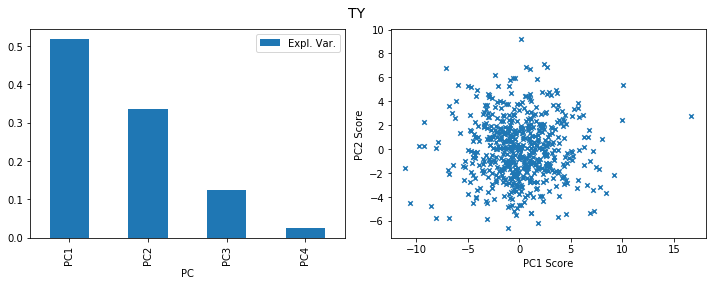

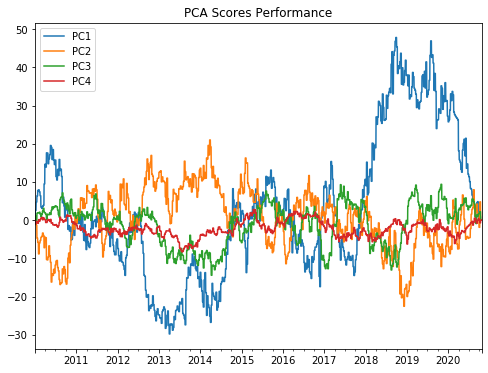

Loadings Matrix:


,AM,LevFunds,Dealers,NonCom
PC1,0.552,-0.642,0.122,-0.518
PC2,-0.489,-0.010,0.812,-0.317
PC3,0.111,-0.472,0.370,0.792
PC4,-0.666,-0.603,-0.434,-0.064


In [53]:
# run PCA see how much variance we can explain by one or two
cols = ['AM', 'LevFunds', 'Dealers', 'NonCom']
ct = 'TY'
prepca_data = ct_dfs[ct].loc[:, cols].diff(1).dropna(how='any')
prepca_data = prepca_data.subtract(prepca_data.mean()).divide(prepca_data.std())
prepca_data = prepca_data.dropna(how='any')
pca = PCA()
pca.fit(prepca_data)
pc_cols = ['PC'+str(i+1) for i in np.arange(pca.n_components_)]

exp_var = pd.DataFrame(zip(pca.explained_variance_ratio_, pc_cols), 
                       columns=['Expl. Var.','PC'])

scores = pd.DataFrame(pca.fit_transform(prepca_data), index=prepca_data.index, columns=pc_cols)
loadings = pd.DataFrame(pca.components_, index=['PC'+str(i) for i in np.arange(1,pca.n_components_+1)], columns=cols)
integrated_scores = scores.cumsum()


fig0, ax0 = plt.subplots(figsize=(10,4),ncols=2)
exp_var.plot.bar(x='PC', y='Expl. Var.', ax=ax0[0])
ax0[1].scatter(scores['PC1'].values, scores['PC2'].values, s=20, marker="x")
#ax0[1].set_xlim(-10,10)
#ax0[1].set_ylim(-10,10)
ax0[1].set_xlabel('PC1 Score')
ax0[1].set_ylabel('PC2 Score')
fig0.suptitle(ct, fontsize=14)
fig0.tight_layout()
fig0.subplots_adjust(top=0.9)

fig, ax = plt.subplots(figsize=(8,6))
integrated_scores.plot(ax=ax)
ax.set_title('PCA Scores Performance')
plt.show()
print('Loadings Matrix:') 
loadings.round(3)

In [6]:
# function to compute dv01 weighted values and shift CoT data 3d forward after

adj_ct_dfs = adjust_ct_dfs(ct_dfs, swaps, oi_avg_len=125)

adj_ct_dfs['TY'].head()



,Com,NonCom,NonRep,AM,LevFunds,Dealers,OtherRep,Com_dv01,Com_pctAvgOI,NonCom_dv01,...,NonRep_pctAvgOI,AM_dv01,AM_pctAvgOI,LevFunds_dv01,LevFunds_pctAvgOI,Dealers_dv01,Dealers_pctAvgOI,OtherRep_dv01,OtherRep_pctAvgOI,7y
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5285
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4801
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.3975
2010-01-06,171617.0,-136356.0,-35261.0,99582.0,-50214.0,-80946.0,66839.0,1.555238e+07,NaN,-1.235694e+07,...,NaN,9.024382e+06,NaN,-4.550524e+06,NaN,-7.335539e+06,NaN,6.057125e+06,NaN,3.4545
2010-01-07,171617.0,-136356.0,-35261.0,99582.0,-50214.0,-80946.0,66839.0,1.556449e+07,NaN,-1.236656e+07,...,NaN,9.031409e+06,NaN,-4.554068e+06,NaN,-7.341251e+06,NaN,6.061842e+06,NaN,3.4765


In [7]:
# resample on Friday's with 'window' sized rolling weekly differences
feat_adj = '_dv01'
window = 26
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1,2])

# determine stationarity of features
# look at correlations
# - Only worth looking at one of Com/NonCom since they're basically just diff sign
# - 
for k, df in r.items():
    print(k, test_adfuller(df, maxlag=1))
for k, df in r.items():
    print(k, df.corr())
r['US'].head(10)

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:207: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])


FV                    tstat          pval
Com_dv01       -4.375874  3.274151e-04
NonCom_dv01    -4.383096  3.179611e-04
NonRep_dv01    -5.839627  3.804264e-07
AM_dv01        -3.050912  3.040568e-02
LevFunds_dv01  -3.552189  6.743676e-03
Dealers_dv01   -4.182056  7.065291e-04
OtherRep_dv01  -3.416817  1.039876e-02
5y             -2.930875  4.187367e-02
5y_lag26       -2.717523  7.105488e-02
5y_lag52       -2.755446  6.492527e-02
5y_fwd1       -22.578942  0.000000e+00
5y_fwd1_sign  -23.161469  0.000000e+00
5y_fwd1_abs   -13.739194  1.102576e-25
TU                    tstat          pval
Com_dv01       -5.646285  1.009619e-06
NonCom_dv01    -5.394271  3.482334e-06
NonRep_dv01    -4.325302  4.014693e-04
AM_dv01        -3.236351  1.797466e-02
LevFunds_dv01  -2.466217  1.239119e-01
Dealers_dv01   -6.064121  1.193080e-07
OtherRep_dv01  -4.138232  8.368010e-04
2y             -2.512069  1.125654e-01
2y_lag26       -1.831215  3.650781e-01
2y_lag52       -1.943418  3.119197e-01
2y_fwd1       -22.1

,Com_dv01,NonCom_dv01,NonRep_dv01,AM_dv01,LevFunds_dv01,Dealers_dv01,OtherRep_dv01,swap_US,swap_US_lag26,swap_US_lag52,swap_US_fwd1,swap_US_fwd1_sign,swap_US_fwd1_abs
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0086,-1.0,0.0086
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0238,-1.0,0.0238
2010-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0257,1.0,0.0257
2010-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0063,1.0,0.0063
2010-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0745,1.0,0.0745
2010-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0155,-1.0,0.0155
2010-02-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0010,1.0,0.0010
2010-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0120,1.0,0.0120
2010-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0077,-1.0,0.0077
2010-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0457,1.0,0.0457


# Extreme values
Not much from classification either, try filtering for extreme values

## Outright

In [54]:
# crossvalidation to evaluate if theres anything here outright

# resample on Friday's with 'window' sized rolling weekly differences
is_start_dt = dt.date(2011, 1, 1)
feat_adj = '_dv01'
unadj_feat = ['AM', 'LevFunds']
filter_feat = 'LevFunds_dv01'
z_thresh = 1.0
clf_params = {'model__class_weight': 'balanced', 'model__solver': 'lbfgs'}

subsq_len = 20
window = 13

outputs = {}
#data
r = get_rolling_cts(adj_ct_dfs, feat_adj, window=window, swap_chg_lags=[1], swap_chg_fwds=[1])

normed_pos = get_norm_cts(r, swaps, 52, swap_chg_fwds=[1, 5,10,20,60])
for ct in CT_SWAP_MAP.keys():
    extr_corr_pos = normed_pos[ct]
    extr_corr_pos = extr_corr_pos[abs(extr_corr_pos[filter_feat])>z_thresh]


    swap = CT_SWAP_MAP[ct][0]
    target = swap+'_fwd'+str(subsq_len)+'_sign'
    target_unadj = swap+'_fwd'+str(subsq_len)
    target_lag = swap#+'_lag'+str(window)
    num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
    sample_weight = swap+'_fwd'+str(subsq_len)+'_abs'

    output_df = run_cv_weighted(extr_corr_pos, ct, feat_adj, is_start_dt, num_features, target, sample_weight=sample_weight, 
                                tss_splits=5, model=LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                                hyperparam_name='C', max_train_size=208, clf_params=clf_params)
    outputs[ct] = output_df
pd.concat(outputs, axis=1)

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:207: RuntimeWarning: invalid value encountered in sign
  new_df[fwdname + '_sign'] = np.sign(new_df[fwdname])
C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:231: RuntimeWarning: invalid value encountered in sign
  ct_df[fwdname+'_sign'] = np.sign(ct_df[fwdname])


,FV,TU,TY,US,WN
beta,"[[0.25728205794355974, -0.16081296703667242, 0...","[[-0.00011464180162352863, 0.00019873384748617...","[[0.1951022809145204, -0.12537740663219638, -0...","[[-0.07797896002876845, -0.20934509988148123, ...","[[2.2389774224055704e-05, -0.00012332615640308..."
best_score,0.539766,0.584541,0.629633,0.54225,0.490115
C,0.568987,0.0001,0.126486,0.828643,0.0001
best_score_ratio,1.38402,1.09056,1.46426,1.28031,1.22529


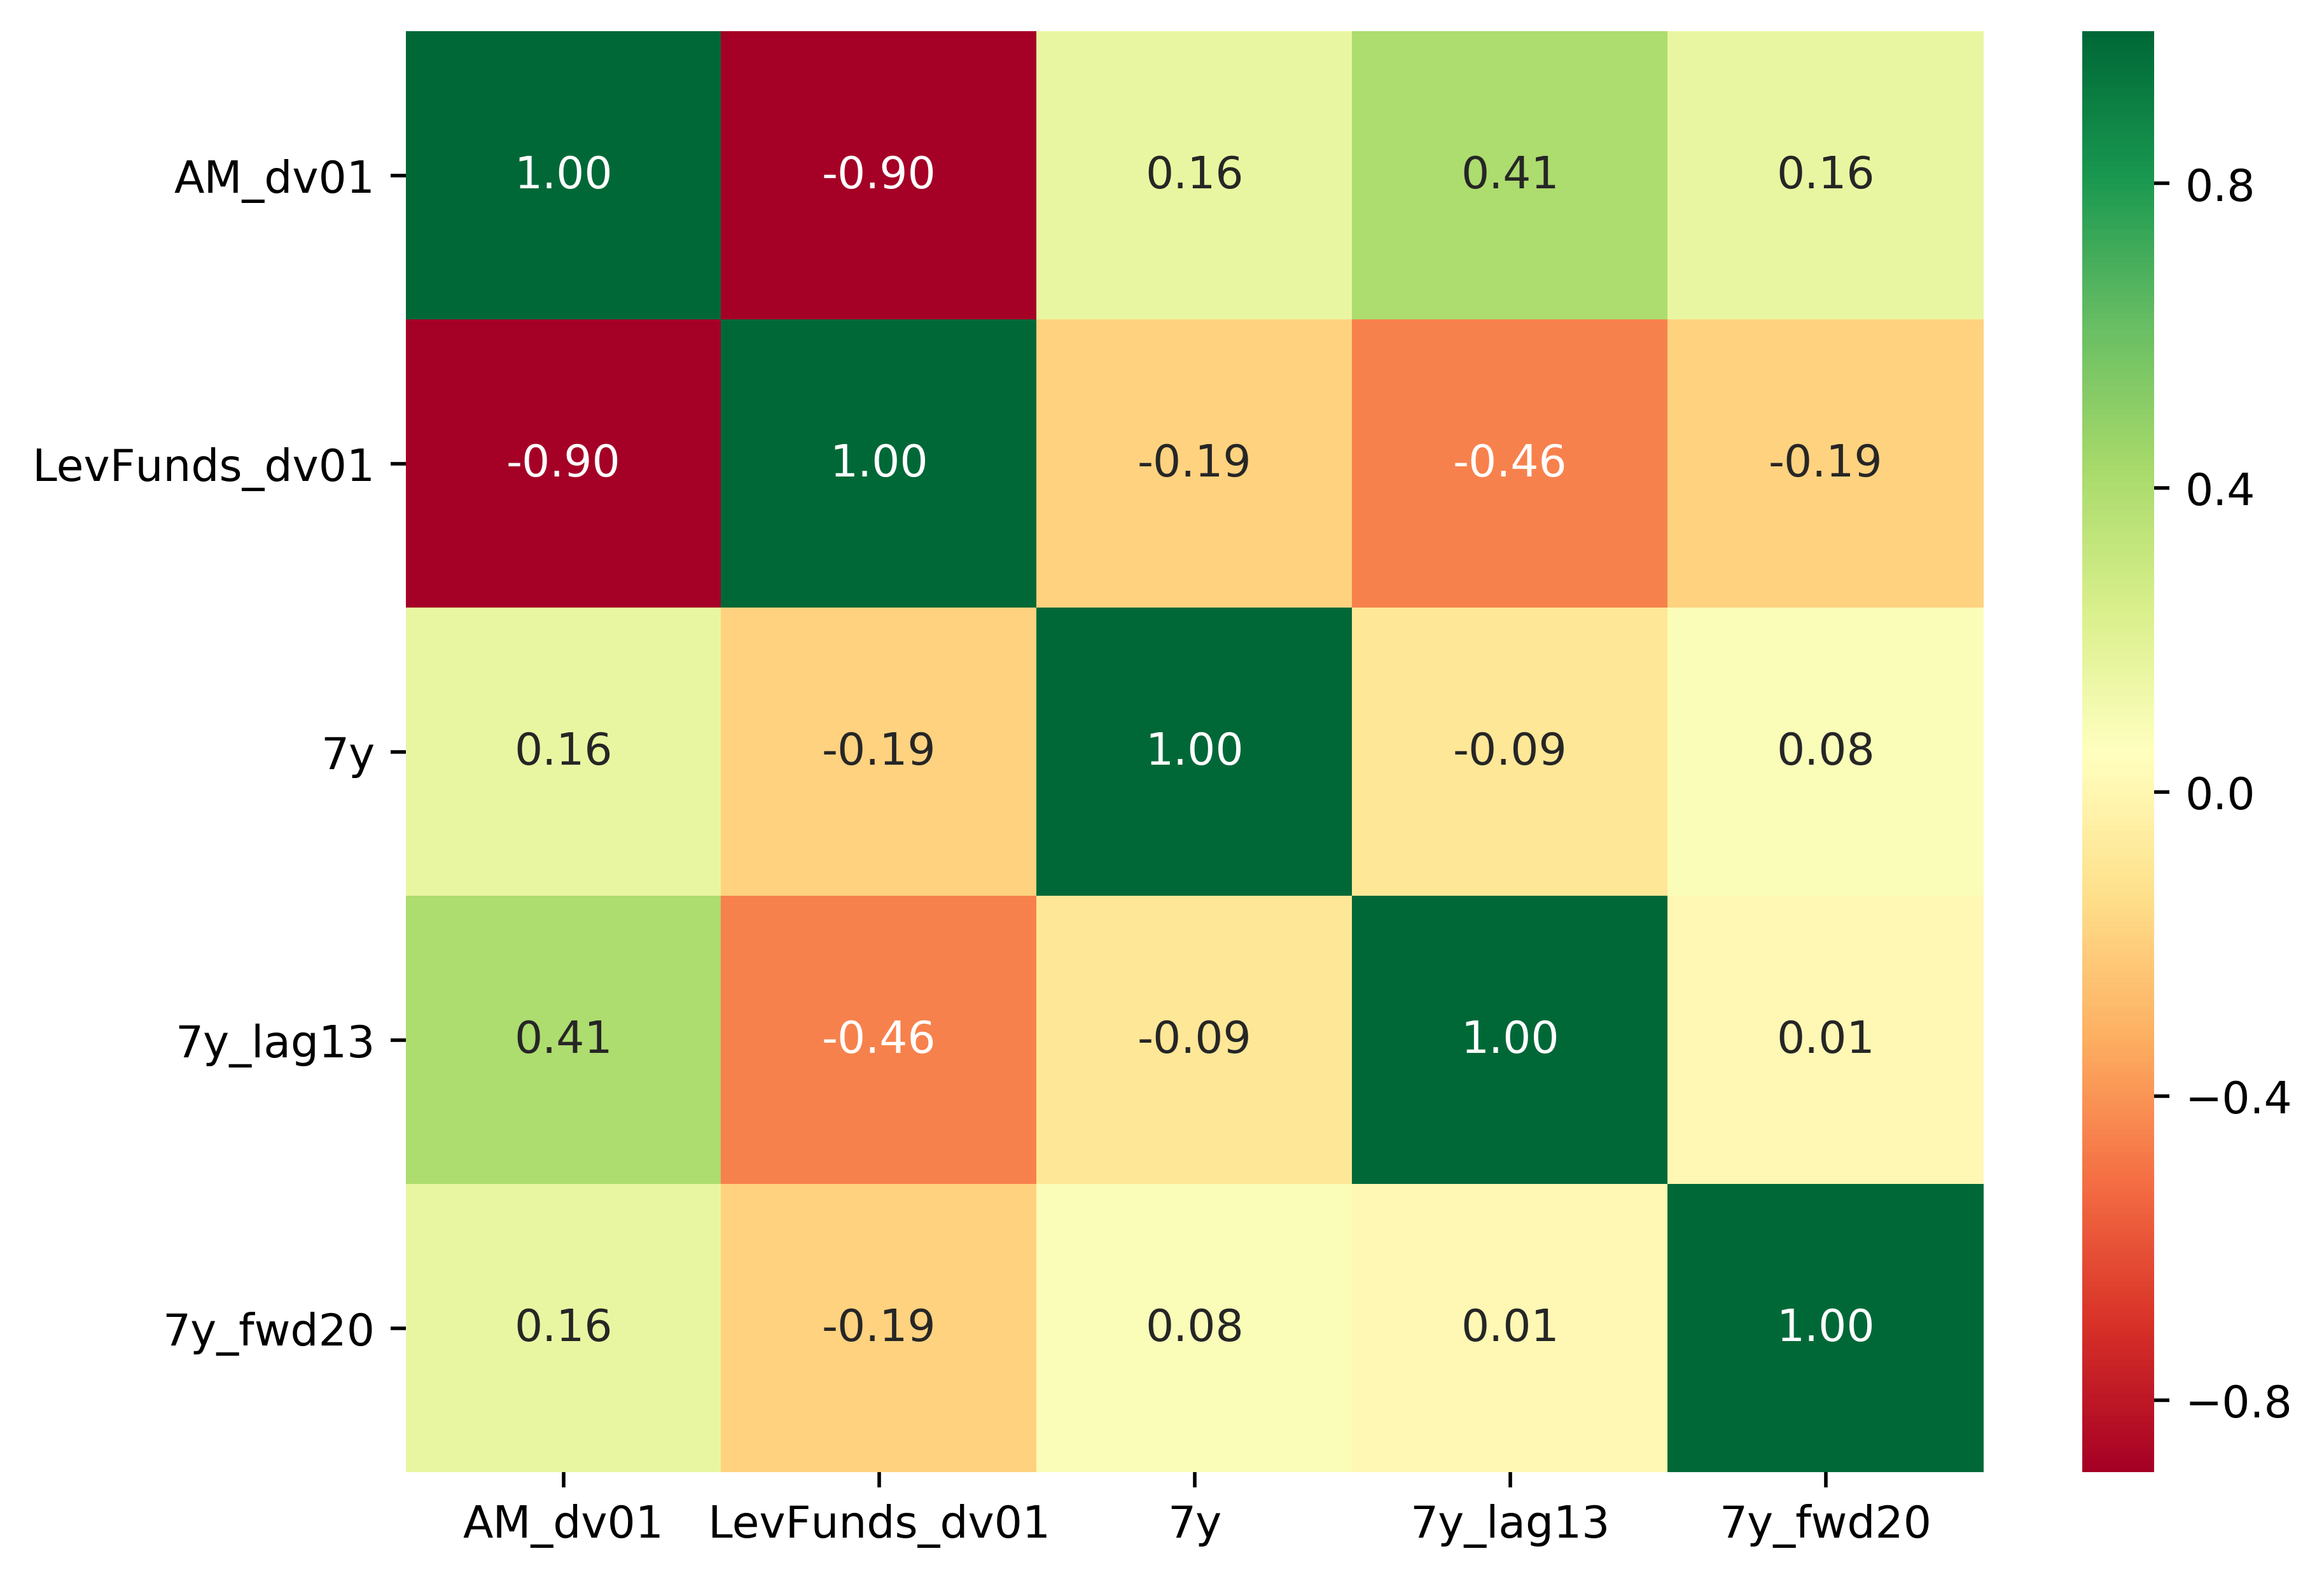

In [55]:
extr_corr_pos = normed_pos['TY']
extr_corr_pos = extr_corr_pos[abs(extr_corr_pos[filter_feat])>z_thresh]
swap = '7y'
target_unadj = swap+'_fwd'+str(subsq_len)
target_lag = swap#+'_lag'+str(window)
target_lag2 = swap+'_lag'+str(window)
num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag, target_lag2])
fig, ax = plt.subplots(figsize=(8,6), dpi=500)
sns.heatmap(extr_corr_pos.loc[:, np.hstack([num_features, target_unadj])].corr(), annot=True, fmt='.2f', cmap='RdYlGn', ax=ax)
plt.show()

In [56]:
outputs['TY'].loc['beta']

array([[ 0.19510228, -0.12537741, -0.03442235]])

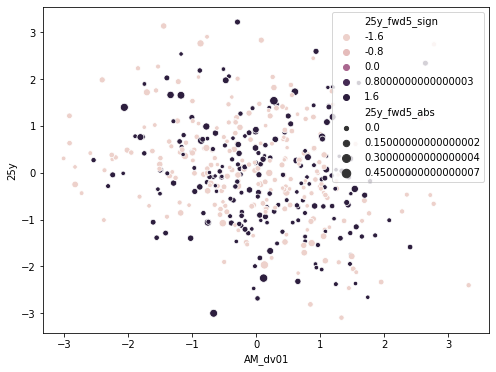

In [10]:
data = normed_pos[ct]
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='AM_dv01', y=target_lag, hue=target, size=sample_weight, data=data, ax=ax)
plt.show()

## Curves

In [22]:
from itertools import combinations
curves = ([c for c in combinations(CT_SIZES.keys(), 2)])

swap_chg_fwds = [1, 5, 10, 20, 60]
window = 13
curve_diffs = get_norm_curve_diffs(curves, r, window, swaps, swap_chg_fwds=swap_chg_fwds)
curve_diffs['FV-TU'].dropna().head(10)

C:\Users\Brendan\FinML\MLFin\ExPtTest\eptest_main.py:288: RuntimeWarning: invalid value encountered in sign
  curve_diff[fwdname + '_sign'] = np.sign(curve_diff[fwdname])


,AM_dv01,Com_dv01,Dealers_dv01,LevFunds_dv01,NonCom_dv01,NonRep_dv01,OtherRep_dv01,5y-2y,5y-2y_lag13,5y-2y_fwd1,...,5y-2y_fwd5_abs,5y-2y_fwd10,5y-2y_fwd10_sign,5y-2y_fwd10_abs,5y-2y_fwd20,5y-2y_fwd20_sign,5y-2y_fwd20_abs,5y-2y_fwd60,5y-2y_fwd60_sign,5y-2y_fwd60_abs
2012-02-03,-0.242084,0.575079,0.985361,0.273423,-0.652148,0.171153,-1.382472,-0.0480,-0.0094,-0.0117,...,0.0215,0.0286,1.0,0.0286,0.0390,1.0,0.0390,0.0300,1.0,0.0300
2012-02-10,-0.573038,0.707049,2.407708,0.456461,-0.803036,0.335326,-2.934515,0.0536,-0.0805,-0.0075,...,0.0071,-0.0025,-1.0,0.0025,0.0240,1.0,0.0240,-0.0205,-1.0,0.0205
2012-02-17,-0.505159,1.048723,2.315468,-0.132350,-1.027200,-0.099966,-1.813565,0.0276,-0.1795,-0.0206,...,0.0096,0.0104,1.0,0.0104,0.1714,1.0,0.1714,-0.0741,-1.0,0.0741
2012-02-24,-0.667650,1.381328,1.915760,0.459323,-0.998979,-1.762121,-1.494140,0.0065,-0.2530,-0.0220,...,0.0200,0.0265,1.0,0.0265,0.1735,1.0,0.1735,-0.1220,-1.0,0.1220
2012-03-02,-0.293780,-0.171863,0.311209,0.158109,0.285120,-0.477298,-0.822213,-0.0400,-0.1455,0.0010,...,0.0065,0.1610,1.0,0.1610,0.1190,1.0,0.1190,-0.1135,-1.0,0.1135
2012-03-09,0.096823,-0.547672,-0.458629,0.424549,0.548837,0.499501,-1.500654,0.0715,-0.2028,-0.0045,...,0.1545,0.1470,1.0,0.1470,-0.0135,-1.0,0.0135,-0.2175,-1.0,0.2175
2012-03-16,-0.403128,0.244909,0.092489,0.916960,-0.001243,-0.444253,-1.653632,0.2000,-0.1240,0.0670,...,0.0075,-0.0420,-1.0,0.0420,-0.1545,-1.0,0.1545,-0.2875,-1.0,0.2875
2012-03-23,-0.198364,0.458254,-1.093197,1.177234,-0.150095,-1.097234,-0.200927,0.1710,-0.0150,0.0038,...,0.0345,-0.1605,-1.0,0.1605,-0.1530,-1.0,0.1530,-0.3255,-1.0,0.3255
2012-03-30,-0.046719,0.307111,0.098973,0.618606,-0.028169,-0.786548,-0.745334,0.1294,-0.0726,-0.0165,...,0.1260,-0.1125,-1.0,0.1125,-0.1280,-1.0,0.1280,-0.2240,-1.0,0.2240
2012-04-06,0.807314,0.562027,-0.101410,-0.344376,-0.564220,-0.009567,-0.907720,0.0130,-0.0190,0.0165,...,0.0135,0.0075,1.0,0.0075,-0.0310,-1.0,0.0310,-0.1480,-1.0,0.1480


In [29]:
# run all and aggregate data up
is_start_dt = dt.date(2011, 1, 1)
unadj_feat = ['NonCom']
model = LogisticRegression(multi_class='auto')
hyperparam_name = 'C'
scorer = 'accuracy'
subsq_len = 20
filter_feat = 'NonCom_dv01'
z_thresh = 0.5
clf_params = {'model__class_weight': 'balanced', 'model__solver': 'lbfgs'}

outputs = {}
searches = {}
for curve_tup in curves:
    curve = '-'.join(list(reversed(curve_tup)))
    swap_curve = '-'.join([CT_SWAP_MAP[a][0] for a in curve.split('-')])
    target = swap_curve+'_fwd'+str(subsq_len)+'_sign'
    sample_weight = swap_curve+'_fwd'+str(subsq_len)+'_abs'
    target_lag = swap_curve#+'_lag'+str(subsq_len)
    num_features = np.hstack([[a+feat_adj for a in unadj_feat], target_lag])
    
    data = curve_diffs[curve].copy(deep=True)
    data = data[abs(data[filter_feat])>z_thresh]
    output_srs = run_cv_weighted(data, curve, feat_adj, is_start_dt, num_features, target, 
                                         sample_weight, tss_splits=5, model=model, hyperparam_name=hyperparam_name,
                                         scorer=scorer, max_train_size=208, clf_params=clf_params)
    outputs[curve] = output_srs

output_df = pd.concat(outputs, axis=1)
output_df

,FV-TU,TY-FV,TY-TU,US-FV,US-TU,US-TY,WN-FV,WN-TU,WN-TY,WN-US
beta,"[[-0.20200305592882808, -0.08235766806720553]]","[[-3.43299600682314e-05, -5.519726888960166e-0...","[[-0.23303411002112628, 0.16969623174984663]]","[[0.00016386892746186486, 5.291451735574046e-05]]","[[0.032600080867412666, 0.3559801510243987]]","[[-4.24313431136428e-05, 6.9382785752330095e-06]]","[[0.0001550894661694236, -3.184153882159324e-05]]","[[0.008653372989501326, 0.01859811217746243]]","[[-7.547870449146106e-05, -7.980965634804855e-...","[[-0.02472317007856772, -0.09222854750155626]]"
best_score,0.446025,0.670301,0.53271,0.511429,0.392703,0.695959,0.668806,0.54892,0.698305,0.57954
C,1.75751,0.0001,1.20679,0.0001,3.72759,0.0001,0.0001,0.00910298,0.0001,0.568987
best_score_ratio,0.856008,1.26536,0.975049,1.04373,0.736319,1.44375,1.35748,0.978509,1.22353,1.29897


In [13]:
output_df['US-FV'].loc['beta']

array([[-5.98155736e-05,  2.32781031e-05]])

# Findings to explore

## Classification
- curve stuff might exist, look at US/WN vs FV/TY 
    - 'AM', 'LevFunds', concurrent swap as features
    - logistic regression
    - accuracy scoring
    - rolling 3-12wk features and 5-20d predictions all look decent
    


# ToDo

## Data
### General
    - Check for general numerical issues
        - US June 2015 contract had a delivery gap of ~5yrs relative to March15 due to tsy issuance in early 2000s
        - see: https://www.cmegroup.com/trading/interest-rates/files/mar-15-jun-15-roll-analysis.pdf
        - the CTD MM swap then gets closer to the 20y... consider interpolating
    - Create offset series for Fridays, lets just shift it 3 days (data stamped tuesday but reported friday+ if holiday)
    - Split train+cv and full test data. Test data lets do 2010-2011 and Oct. 2018+
### Feature Generation:
Start evaluating training data visually, we need to work on stationary time series so let's do the transforms upfront:
        - DV01-weighted positions or % OI will be more informative, dur*px/100*ct_size/10000
        - Rolling x-week changes in transformed CoT data
            - Consider PCA of this CoT data and look at consistency of loadings over time
        - Rolling x-week changes in swap data
        - Indicator variables of whether the CoT change was 'same-way' as market move
    
    

## (this is done, just have to backtest TYs) 
## Modelling
### Feature Selection
Let's do feature selection second- random forest type feature importance algos, lasso
- First pass we can look at a few sets of x-lagged 1m changes(e.g. 1m lagged 1m changes, 2m lagged 1m changes, etc)
    
### Regression
Features need to be fit on a weekly basis- this data is weekly
- We could consider either modeling on Tuesday data or Friday, but need to evaluate residuals based on Friday
- Residual evaluation can be daily, not sure how valuable that'd be
Simple setups first
- lagged aggregated changes, including conditional on same way stuff
More complicated
- Maybe we do our own type of gridsearch CV with the parameter being the length of the window to aggregate changes

## Modelling
### Curve
- differences in rolling (raw and z-scored) increases to predict subsequent curve
    - construct all the pairwise combinations
    - compute features and targets
    - run the same process as above with outrights
- try predicting signs rather than regressions next
- (done) would have to implement our own gridsearchcv in order to use weighted scoring
- try SVC next

## Presentation
### Data
- bar charts of ADF p-values
- neg mse vs ridge alpha plot

## Extra Credit
Can we use some classification algorithms to filter when to trade or not to trade